## Texture synthesis with CNN

Based on paper: https://arxiv.org/pdf/1505.07376.pdf

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as TF
from PIL import Image
from time import time
import matplotlib.pyplot as plt
from collections import OrderedDict
import gc

In [4]:
def getmodel(last_layer=None):
    m=models.vgg19(pretrained=True).eval().requires_grad_(False).cuda()
    m=next(m.children()) # extract convolutional part
    mods=[]
    idxs={}
    for c in m.children():
        type=c.__class__.__name__.lower().replace('2d','').replace('max','')
        idx=idxs.setdefault(type,0)+1
        idxs[type]=idx
        name='%s%s'%(type,idx)
        mods.append((name,c))
        if name==last_layer: break
    return nn.Sequential(OrderedDict(mods))

# surprising thing w/ gpu oom: ipython saves cell outputs in history, so if cell returns model it is
# saved and not garbage collected, so after a number of cell runs big model stored on gpu leads to oom,
# print(...) avoids that
print(getmodel())

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU(inplace=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU(inplace=True)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu6): ReLU(inplace=True)
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu7): ReLU(inplace=True)
  (conv8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 

In [5]:
def hookmodel(layers):
    outs=OrderedDict()
    mod2name={}
    def hook(mod,inp,out): outs[mod2name[mod]]=out
    m=getmodel(layers[-1])
    for name,c in m.named_children():
        for l in layers:
            if name==l:
                mod2name[c]=name
                c.register_forward_hook(hook)
                break
    return m,outs

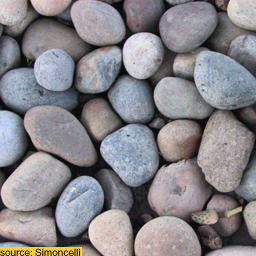

In [125]:
# path='stones.jpg'
path='pebbles.jpg'
im=Image.open(path)
im

In [87]:
# taken from https://pytorch.org/docs/1.2.0/torchvision/models.html
means=torch.tensor([0.485,0.456,0.406])
stds=torch.tensor([0.229,0.224,0.225])

prepr=TF.Compose([
    TF.ToTensor(),
    TF.Normalize(means.tolist(),stds.tolist()),
    TF.Lambda(lambda x:x[None].cuda())
])
postp=TF.Compose([
    TF.Lambda(lambda x:x[0].cpu()),
    TF.Normalize((-means/stds).tolist(),(1./stds).tolist()),
    TF.Lambda(lambda x:x.clamp(0,1)),
    TF.ToPILImage()
])
imt=prepr(im)
imt.shape

torch.Size([1, 3, 256, 256])

In [92]:
style_layers=['pool1','pool2','pool3','pool4']
m,outs=hookmodel(style_layers)

In [93]:
def getgrams(x):
    outs.clear()
    m(x) # features are saved via hooks
    grams=[]
    for feats in outs.values():
        b,c,h,w=feats.shape
        feats=feats.view((b,c,h*w))
        grams.append(feats@feats.transpose(1,2)/(h*w))
    return grams

In [94]:
imgrams=getgrams(imt)
[g.shape for g in imgrams]

[torch.Size([1, 64, 64]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 256, 256]),
 torch.Size([1, 512, 512])]

In paper loss is scaled by $\frac{1}{4N^2M^2}$. Below $\frac{1}{N^2}$ is contributed by mse_loss() with default reduction='mean', since gram matrix is NxN. Division by 4 is done explicitly, but this probably doesn't make much impact. $\frac{1}{M^2}$ is contributed by getgrams(): each dot product of 2 channels in gram matrix is divided by $M=hw$, i.e. average correlation between channels instead of sum. Because it's done in getgrams(), $M$ (and thus dimensions) of source image and optimization target may be different.

In [95]:
def getloss(grams1,grams2):
    return sum(F.mse_loss(g1,g2) for g1,g2 in zip(grams1,grams2))/4

In [122]:
x=(torch.randn(1,3,200,200)/10.).cuda().requires_grad_()

Below we do same 2000 iterations as in the example by paper author: https://github.com/leongatys/DeepTextures/blob/master/Example.ipynb. But we don't do histogram matching.

1 55.953983306884766
2 55.95073699951172
3 55.420719146728516
4 53.82074737548828
5 50.1630744934082
6 40.71251678466797
7 29.752593994140625
8 23.587007522583008
9 19.096893310546875
10 15.997137069702148
11 13.860662460327148
12 12.051305770874023
13 10.078977584838867
14 8.529129028320312
15 7.781171798706055
16 7.203183650970459
17 6.782771587371826
18 6.227753639221191
19 5.489070892333984
20 4.9643988609313965
21 4.777712821960449
22 4.526240825653076
23 4.257369518280029
24 3.9372406005859375
25 3.6330738067626953
26 3.517646551132202
27 3.293837070465088
28 3.151089668273926
29 2.9512240886688232
30 2.811038017272949
31 2.7257018089294434
32 2.6291346549987793
33 2.492002248764038
34 2.329435110092163
35 2.274543046951294
36 2.174910545349121
37 2.1131651401519775
38 2.022059679031372
39 1.931398868560791
40 1.8640379905700684
41 1.7939095497131348
42 1.7496888637542725
43 1.7011524438858032
44 1.6339819431304932
45 1.581585168838501
46 1.5279911756515503
47 1.4941322803497314


357 0.21749001741409302
358 0.21715745329856873
359 0.21689735352993011
360 0.21657362580299377
361 0.21626710891723633
362 0.21590960025787354
363 0.2155677229166031
364 0.2152639627456665
365 0.21504536271095276
366 0.21484193205833435
367 0.21452945470809937
368 0.21417146921157837
369 0.21384775638580322
370 0.21357060968875885
371 0.21326152980327606
372 0.21293261647224426
373 0.21262015402317047
374 0.2122824490070343
375 0.21197375655174255
376 0.21180374920368195
377 0.21155235171318054
378 0.2113972306251526
379 0.21115031838417053
380 0.21087901294231415
381 0.21055395901203156
382 0.2102370262145996
383 0.2099682241678238
384 0.20968197286128998
385 0.2093854546546936
386 0.20914968848228455
387 0.2089507281780243
388 0.20869112014770508
389 0.20838579535484314
390 0.2081017792224884
391 0.20785579085350037
392 0.2076035439968109
393 0.20729653537273407
394 0.2070292830467224
395 0.2068268358707428
396 0.20659655332565308
397 0.20635156333446503
398 0.20613552629947662
399 

701 0.17046457529067993
702 0.17041629552841187
703 0.17036066949367523
704 0.17030903697013855
705 0.17024973034858704
706 0.17019157111644745
707 0.17012923955917358
708 0.1700667142868042
709 0.17000700533390045
710 0.1699509620666504
711 0.1698920726776123
712 0.1698300540447235
713 0.16976895928382874
714 0.16971300542354584
715 0.16965728998184204
716 0.16959929466247559
717 0.1695401519536972
718 0.16948021948337555
719 0.1694285273551941
720 0.16937503218650818
721 0.16931650042533875
722 0.16926366090774536
723 0.16920995712280273
724 0.16915227472782135
725 0.16909551620483398
726 0.16903658211231232
727 0.16897955536842346
728 0.16892334818840027
729 0.16886623203754425
730 0.1688092052936554
731 0.168752521276474
732 0.1686939299106598
733 0.16863472759723663
734 0.16857829689979553
735 0.16853025555610657
736 0.16848593950271606
737 0.16844582557678223
738 0.16839754581451416
739 0.16834864020347595
740 0.16829341650009155
741 0.16824136674404144
742 0.1681920886039734
743

1043 0.1575232744216919
1044 0.15750104188919067
1045 0.15747851133346558
1046 0.15745475888252258
1047 0.15743093192577362
1048 0.15740709006786346
1049 0.1573828011751175
1050 0.15735873579978943
1051 0.15733449161052704
1052 0.15730901062488556
1053 0.15728288888931274
1054 0.1572570502758026
1055 0.15723073482513428
1056 0.1572059690952301
1057 0.15718215703964233
1058 0.15715786814689636
1059 0.1571330577135086
1060 0.15711000561714172
1061 0.15708881616592407
1062 0.15706679224967957
1063 0.1570436656475067
1064 0.15701870620250702
1065 0.15699364244937897
1066 0.15697085857391357
1067 0.15694671869277954
1068 0.15692263841629028
1069 0.15689915418624878
1070 0.15687689185142517
1071 0.15685294568538666
1072 0.15682834386825562
1073 0.15680521726608276
1074 0.15678037703037262
1075 0.15675534307956696
1076 0.1567327380180359
1077 0.15671119093894958
1078 0.1566891372203827
1079 0.1566677987575531
1080 0.15664756298065186
1081 0.15662455558776855
1082 0.1566036492586136
1083 0.156

1373 0.15196989476680756
1374 0.15195968747138977
1375 0.15194916725158691
1376 0.15193775296211243
1377 0.1519266664981842
1378 0.15191689133644104
1379 0.15190690755844116
1380 0.15189525485038757
1381 0.15188464522361755
1382 0.15187343955039978
1383 0.1518617868423462
1384 0.15185092389583588
1385 0.1518392115831375
1386 0.15182828903198242
1387 0.15181753039360046
1388 0.15180642902851105
1389 0.1517956703901291
1390 0.15178453922271729
1391 0.15177389979362488
1392 0.1517631709575653
1393 0.15175162255764008
1394 0.151741161942482
1395 0.15173037350177765
1396 0.15171974897384644
1397 0.1517093926668167
1398 0.1516977697610855
1399 0.15168623626232147
1400 0.1516754925251007
557.9882276058197 s
1401 0.15166465938091278
1402 0.1516537070274353
1403 0.1516430824995041
1404 0.15163251757621765
1405 0.1516222357749939
1406 0.1516118049621582
1407 0.15160059928894043
1408 0.15158967673778534
1409 0.15157923102378845
1410 0.15156888961791992
1411 0.15155896544456482
1412 0.151548624038

1702 0.14904704689979553
1703 0.14903943240642548
1704 0.14903169870376587
1705 0.14902444183826447
1706 0.14901721477508545
1707 0.14900946617126465
1708 0.14900174736976624
1709 0.14899452030658722
1710 0.14898699522018433
1711 0.14897921681404114
1712 0.14897167682647705
1713 0.14896388351917267
1714 0.148956760764122
1715 0.14894965291023254
1716 0.14894245564937592
1717 0.14893507957458496
1718 0.14892803132534027
1719 0.14892053604125977
1720 0.14891381561756134
1721 0.1489071249961853
1722 0.14889970421791077
1723 0.1488930881023407
1724 0.14888650178909302
1725 0.14887934923171997
1726 0.14887267351150513
1727 0.14886561036109924
1728 0.14885833859443665
1729 0.14885179698467255
1730 0.1488458216190338
1731 0.14883944392204285
1732 0.14883238077163696
1733 0.14882522821426392
1734 0.1488179862499237
1735 0.14881137013435364
1736 0.14880454540252686
1737 0.14879709482192993
1738 0.148789644241333
1739 0.14878293871879578
1740 0.14877581596374512
1741 0.14876866340637207
1742 0.1

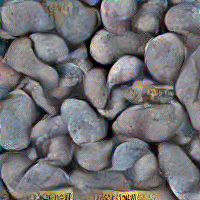

In [123]:
lr=1.
maxiter=2000

opt=optim.LBFGS([x],lr=lr)
t0=time()
niter=0
while niter<maxiter:
    def closure():
        global niter
        niter+=1
        opt.zero_grad()
        grams=getgrams(x)
        loss=getloss(grams,imgrams)
        print(niter,loss.item())
        loss.backward()
        if niter%100==0: print(time()-t0,'s')
        return loss
    opt.step(closure)

print('total time:',time()-t0,'s')
postp(x)

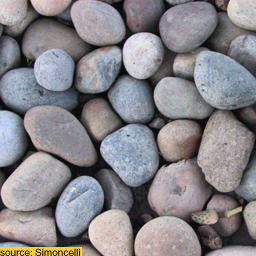

In [126]:
im